# Transfer learning using MobileNetV2

# Transfer learning involves using a pre-trained model and then modifying the final layer to have the correct number of classes.
# This is a good way to save time and improve the accuracy of the model.

# Steps are as follows:
# 1. Load the pre-trained model
# 2. Modify the final layer to have the correct number of classes
# 3. Train the model on the new dataset
# 4. Save the model

In [6]:
# import the necessary libraries to perform the above steps using pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split, ConcatDataset
from torchvision import transforms, models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import numpy as np
import os
import json

# ensure that Mac M1 GPU is being used
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# load the pre-trained model
model = models.mobilenet_v2(pretrained=True)

# print the model architecture
#

/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:


# save path to training data at /Users/fergusproctor/Library/CloudStorage/OneDrive-Personal/Documents/Robotics Masters/Vision por Computadora/Proyecto Vision/Proyecto Vision-Fergus’s MacBook Air
training_data_path = "/Users/fergusproctor/dev/vision_data"


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225]))
])

# Get all subdirectories in the training data path

subdirs = [d for d in os.listdir(training_data_path) if os.path.isdir(os.path.join(training_data_path, d))]
print(subdirs)
# Create a list to store datasets from each folder
datasets_list = []

# Load data from each subfolder
for subdir in subdirs:
    subdir_path = os.path.join(training_data_path, subdir)
    dataset = datasets.ImageFolder(root=subdir_path, transform=train_transforms)
    print(f"Number of images in {subdir}: {len(dataset)}")
    datasets_list.append(dataset)


full_training_data = ConcatDataset(datasets_list)



# Calculate the number of samples for the test set (10% of the total data)
test_size = int(0.1 * len(full_training_data))  # 10% of the dataset
train_size = len(full_training_data) - test_size  # Remaining 90% for training


# Split the data into training and test sets
train_data, test_data = random_split(full_training_data, [train_size, test_size])







# Create DataLoaders for both training and test datasets
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Print the number of images in the training and test sets
print(f"Number of images in the training set: {len(train_data)}")
print(f"Number of images in the test set: {len(test_data)}")





['doro_sign_language', 'c1', 'natalia', 'asl_alphabet_train', 'fergus']
Number of images in doro_sign_language: 2703
Number of images in c1: 2900
Number of images in natalia: 2603
Number of images in asl_alphabet_train: 87000
Number of images in fergus: 2900
Number of images in the training set: 88296
Number of images in the test set: 9810


AttributeError: 'ConcatDataset' object has no attribute 'classes'

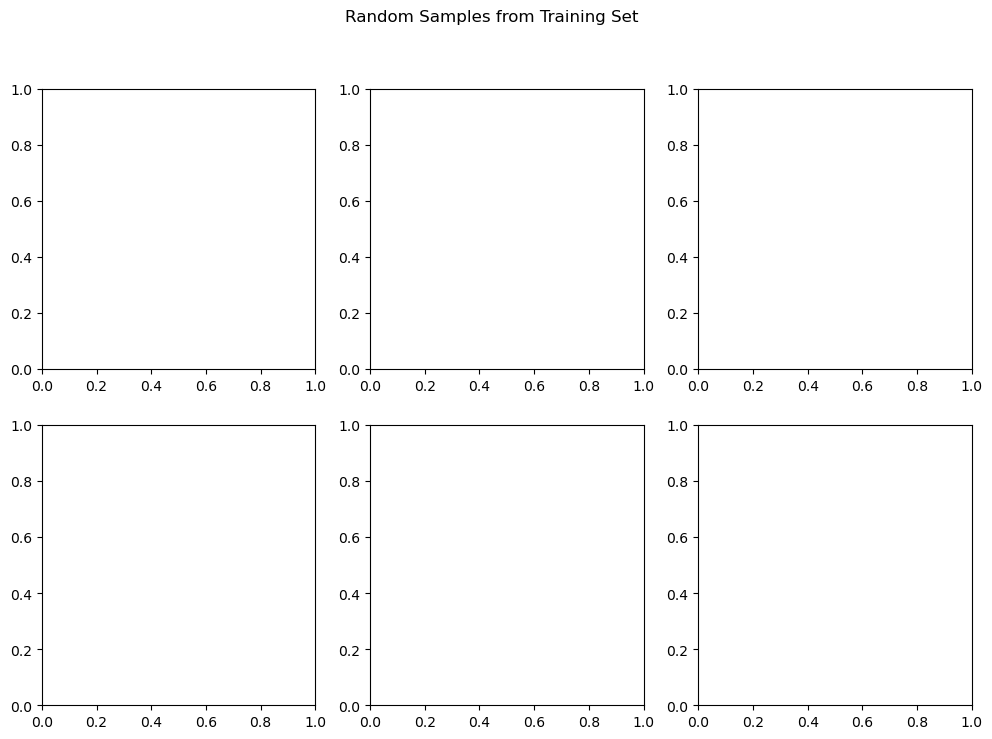

In [19]:
# Plot random samples from training and test sets
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T

def show_random_images(dataset, num_images=6, title=""):
    # Create inverse transform to convert tensors back to images
    inv_normalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(title)
    
    # Get random indices
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    for idx, ax in zip(indices, axes.flat):
        # Get image and label
        img, label = dataset[idx]
        
        # Convert tensor back to image
        img = inv_normalize(img)
        img = torch.clamp(img, 0, 1)
        
        # Convert to numpy and transpose
        img = img.numpy().transpose(1, 2, 0)
        
        # Get class name from dataset
        if hasattr(dataset, 'classes'):
            class_name = dataset.classes[label]
        else:
            # For subset, get classes from original dataset
            class_name = dataset.dataset.classes[label]
            
        # Display image
        ax.imshow(img)
        ax.axis('off')
        # Make title more descriptive with both label index and class name
        ax.set_title(f'Label {label}: {class_name}', fontsize=8, wrap=True)

    plt.tight_layout()
    plt.show()

# Show random images from training set
show_random_images(train_data, title="Random Samples from Training Set")

# Show random images from test set  
show_random_images(test_data, title="Random Samples from Test Set")




In [12]:
# Load the class lookup dictionary
with open('../../../data/class_lookup.json', 'r') as f:
    class_lookup = json.load(f)

print(class_lookup)



{'0': 'a', '1': 'b', '2': 'c', '3': 'd', '4': 'e', '5': 'f', '6': 'g', '7': 'h', '8': 'i', '9': 'j', '10': 'k', '11': 'l', '12': 'm', '13': 'n', '14': 'o', '15': 'p', '16': 'q', '17': 'r', '18': 's', '19': 't', '20': 'u', '21': 'v', '22': 'w', '23': 'x', '24': 'y', '25': 'z', '26': 'del', '27': 'nothing', '28': 'space'}


In [5]:
# create data loaders which we can pass to model later
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [27]:
# update the final layer of the model to have the correct number of classes, which is the 
# number of classes in the training data
num_classes = len(train_data.classes)
print(num_classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# print the model architecture
print(model)

AttributeError: 'Subset' object has no attribute 'classes'

In [7]:
print(device)

mps


In [8]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
# Freeze all layers except the classifier
for param in model.features.parameters():
    param.requires_grad = False

# Verify only classifier is trainable
for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)



model = model.to(device)

print(device)

# Number of epochs
num_epochs = 8


# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:  # training_data is your DataLoader
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_data)}")




mps
Epoch 1/8, Loss: 0.04649615328887413
Epoch 2/8, Loss: 0.03609464812096051
Epoch 3/8, Loss: 0.029289777056619733
Epoch 4/8, Loss: 0.02474945830050404
Epoch 5/8, Loss: 0.021604294026339496
Epoch 6/8, Loss: 0.01928568347203777
Epoch 7/8, Loss: 0.01750983071053165
Epoch 8/8, Loss: 0.01608363528056772


In [11]:
# save model to device
# Save the model's state dictionary
torch.save(model.state_dict(), 'mobilenet_asl_100_percent_5_epoch.pth')
print("Model saved successfully!")


Model saved successfully!


In [22]:
import torch
from torchvision import models

# Instantiate the model (same architecture as before)
model = models.mobilenet_v2(pretrained=False)

# If you made changes to the model, apply them (e.g., modifying the classifier)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 29)

# Load the saved model weights
model.load_state_dict(torch.load('mobilenet_asl_100_percent_5_epoch.pth'))

# Set the model to evaluation mode for inference
model.eval()

print("Model loaded successfully!")


/var/folders/dv/3vlkd_t53j9gr9ggfhz4wg2w0000gn/T/ipykernel_18524/2037578909.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenet_

Model loaded successfully!


In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [29]:
# test out model

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and actual labels
predictions = []
actual_labels = []
running_test_loss = 0.0

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Store predictions and labels
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predictions)
print(f"Test Loss: {running_test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(actual_labels, predictions))

# Create confusion matrix
cm = confusion_matrix(actual_labels, predictions)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

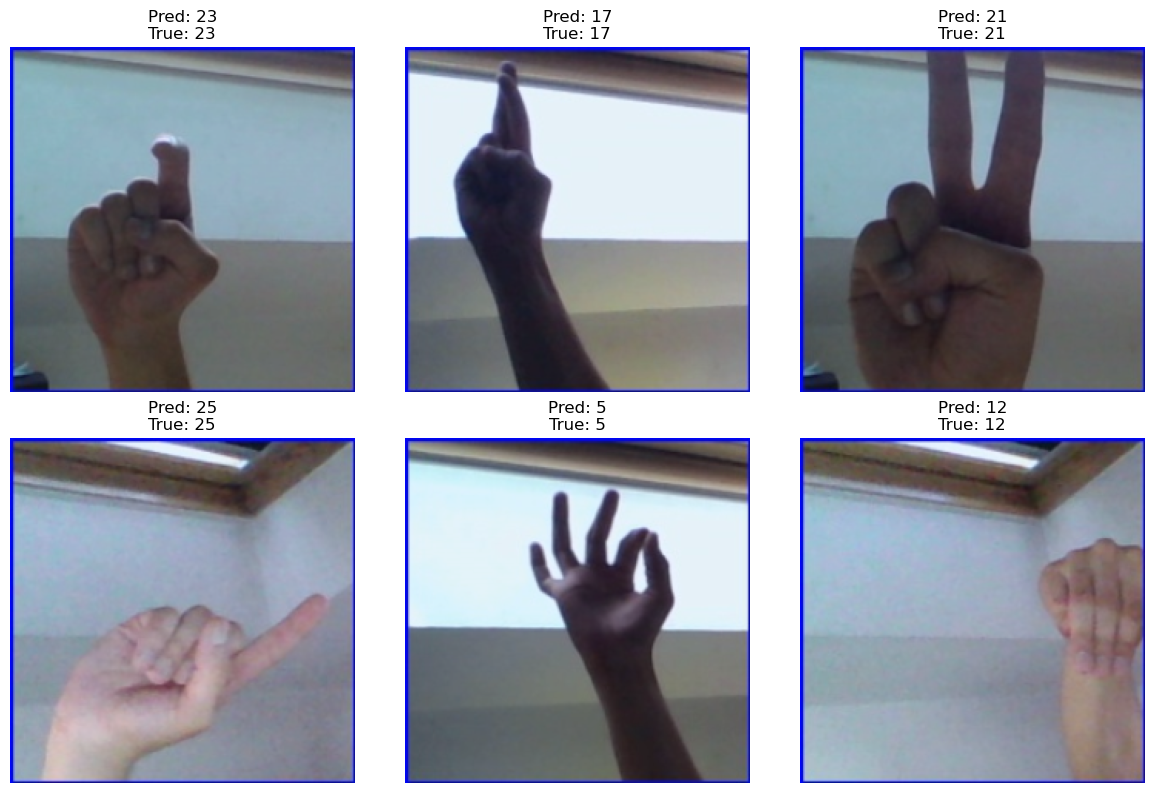

In [14]:
# show test images, predictions and true classes alongside each other
# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs.data, 1)

# Convert tensors to numpy arrays
images = images.cpu().numpy()
predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

# Plot 6 images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for idx in range(6):
    # Get the image and normalize it
    img = np.transpose(images[idx], (1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())
    
    # Plot image
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Pred: {predicted[idx]}\nTrue: {labels[idx]}')

plt.tight_layout()
plt.show()